In [1]:
import joblib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np

import os
os.chdir('../src')

from specs import m_to_label, downstream_scores, layer_map, assign_color
from plot_utils import make_correlation_plot, load_results, make_barplot, layerwise_rsa, plot_components, make_full_barplot

### Gather results

In [2]:
#Run this cell if not calculated yet...
results_df = load_results('../from_scratch')
results_df.to_csv('../outputs/results-summarized.csv')

38it [19:25, 30.67s/it]
/mnt/ssd1/lpepino/braindnn/braindnn-enhanced/src/plot_utils.py:96: RuntimeWarning: Mean of empty slice
  results_df[f'REG_{d}_mean'] = results_df.apply(lambda row: np.nanmean(row[subj_cols]), axis=1)
/mnt/ssd1/lpepino/braindnn/braindnn-enhanced/src/plot_utils.py:96: RuntimeWarning: Mean of empty slice
  results_df[f'REG_{d}_mean'] = results_df.apply(lambda row: np.nanmean(row[subj_cols]), axis=1)
/mnt/ssd1/lpepino/braindnn/braindnn-enhanced/src/plot_utils.py:96: RuntimeWarning: Mean of empty slice
  results_df[f'REG_{d}_mean'] = results_df.apply(lambda row: np.nanmean(row[subj_cols]), axis=1)
/mnt/ssd1/lpepino/braindnn/braindnn-enhanced/src/plot_utils.py:96: RuntimeWarning: Mean of empty slice
  results_df[f'REG_{d}_mean'] = results_df.apply(lambda row: np.nanmean(row[subj_cols]), axis=1)


### Or load the summarized results

In [3]:
#Else, just read the precalculated results
results_df = pd.read_csv('../outputs/results-summarized.csv')

all_models_layer_rsa = []
for m in layer_map.keys():
    data = layerwise_rsa('../rdm_layerwise', m)
    data['rsa_b2021_max'] = max(data['lw_B2021']) if data['lw_B2021'] is not None else None
    data['rsa_nh2015_max'] = max(data['lw_NH2015']) if data['lw_NH2015'] is not None else None
    data['rsa_b2021_se'] = data['lw_std_B2021']them[np.argmax(data['lw_B2021'])] if data['lw_B2021'] is not None else None
    data['rsa_nh2015_se'] = data['lw_std_NH2015'][np.argmax(data['lw_NH2015'])] if data['lw_NH2015'] is not None else None
    all_models_layer_rsa.append(data)

df_layerwise_rsa = pd.DataFrame(all_models_layer_rsa)
results_df = pd.merge(df_layerwise_rsa, results_df, left_on='model', right_on='model', how='right')
results_df = results_df.loc[results_df['model']!='mel256-ec-base-dynamic']

### Figure 2

16.0


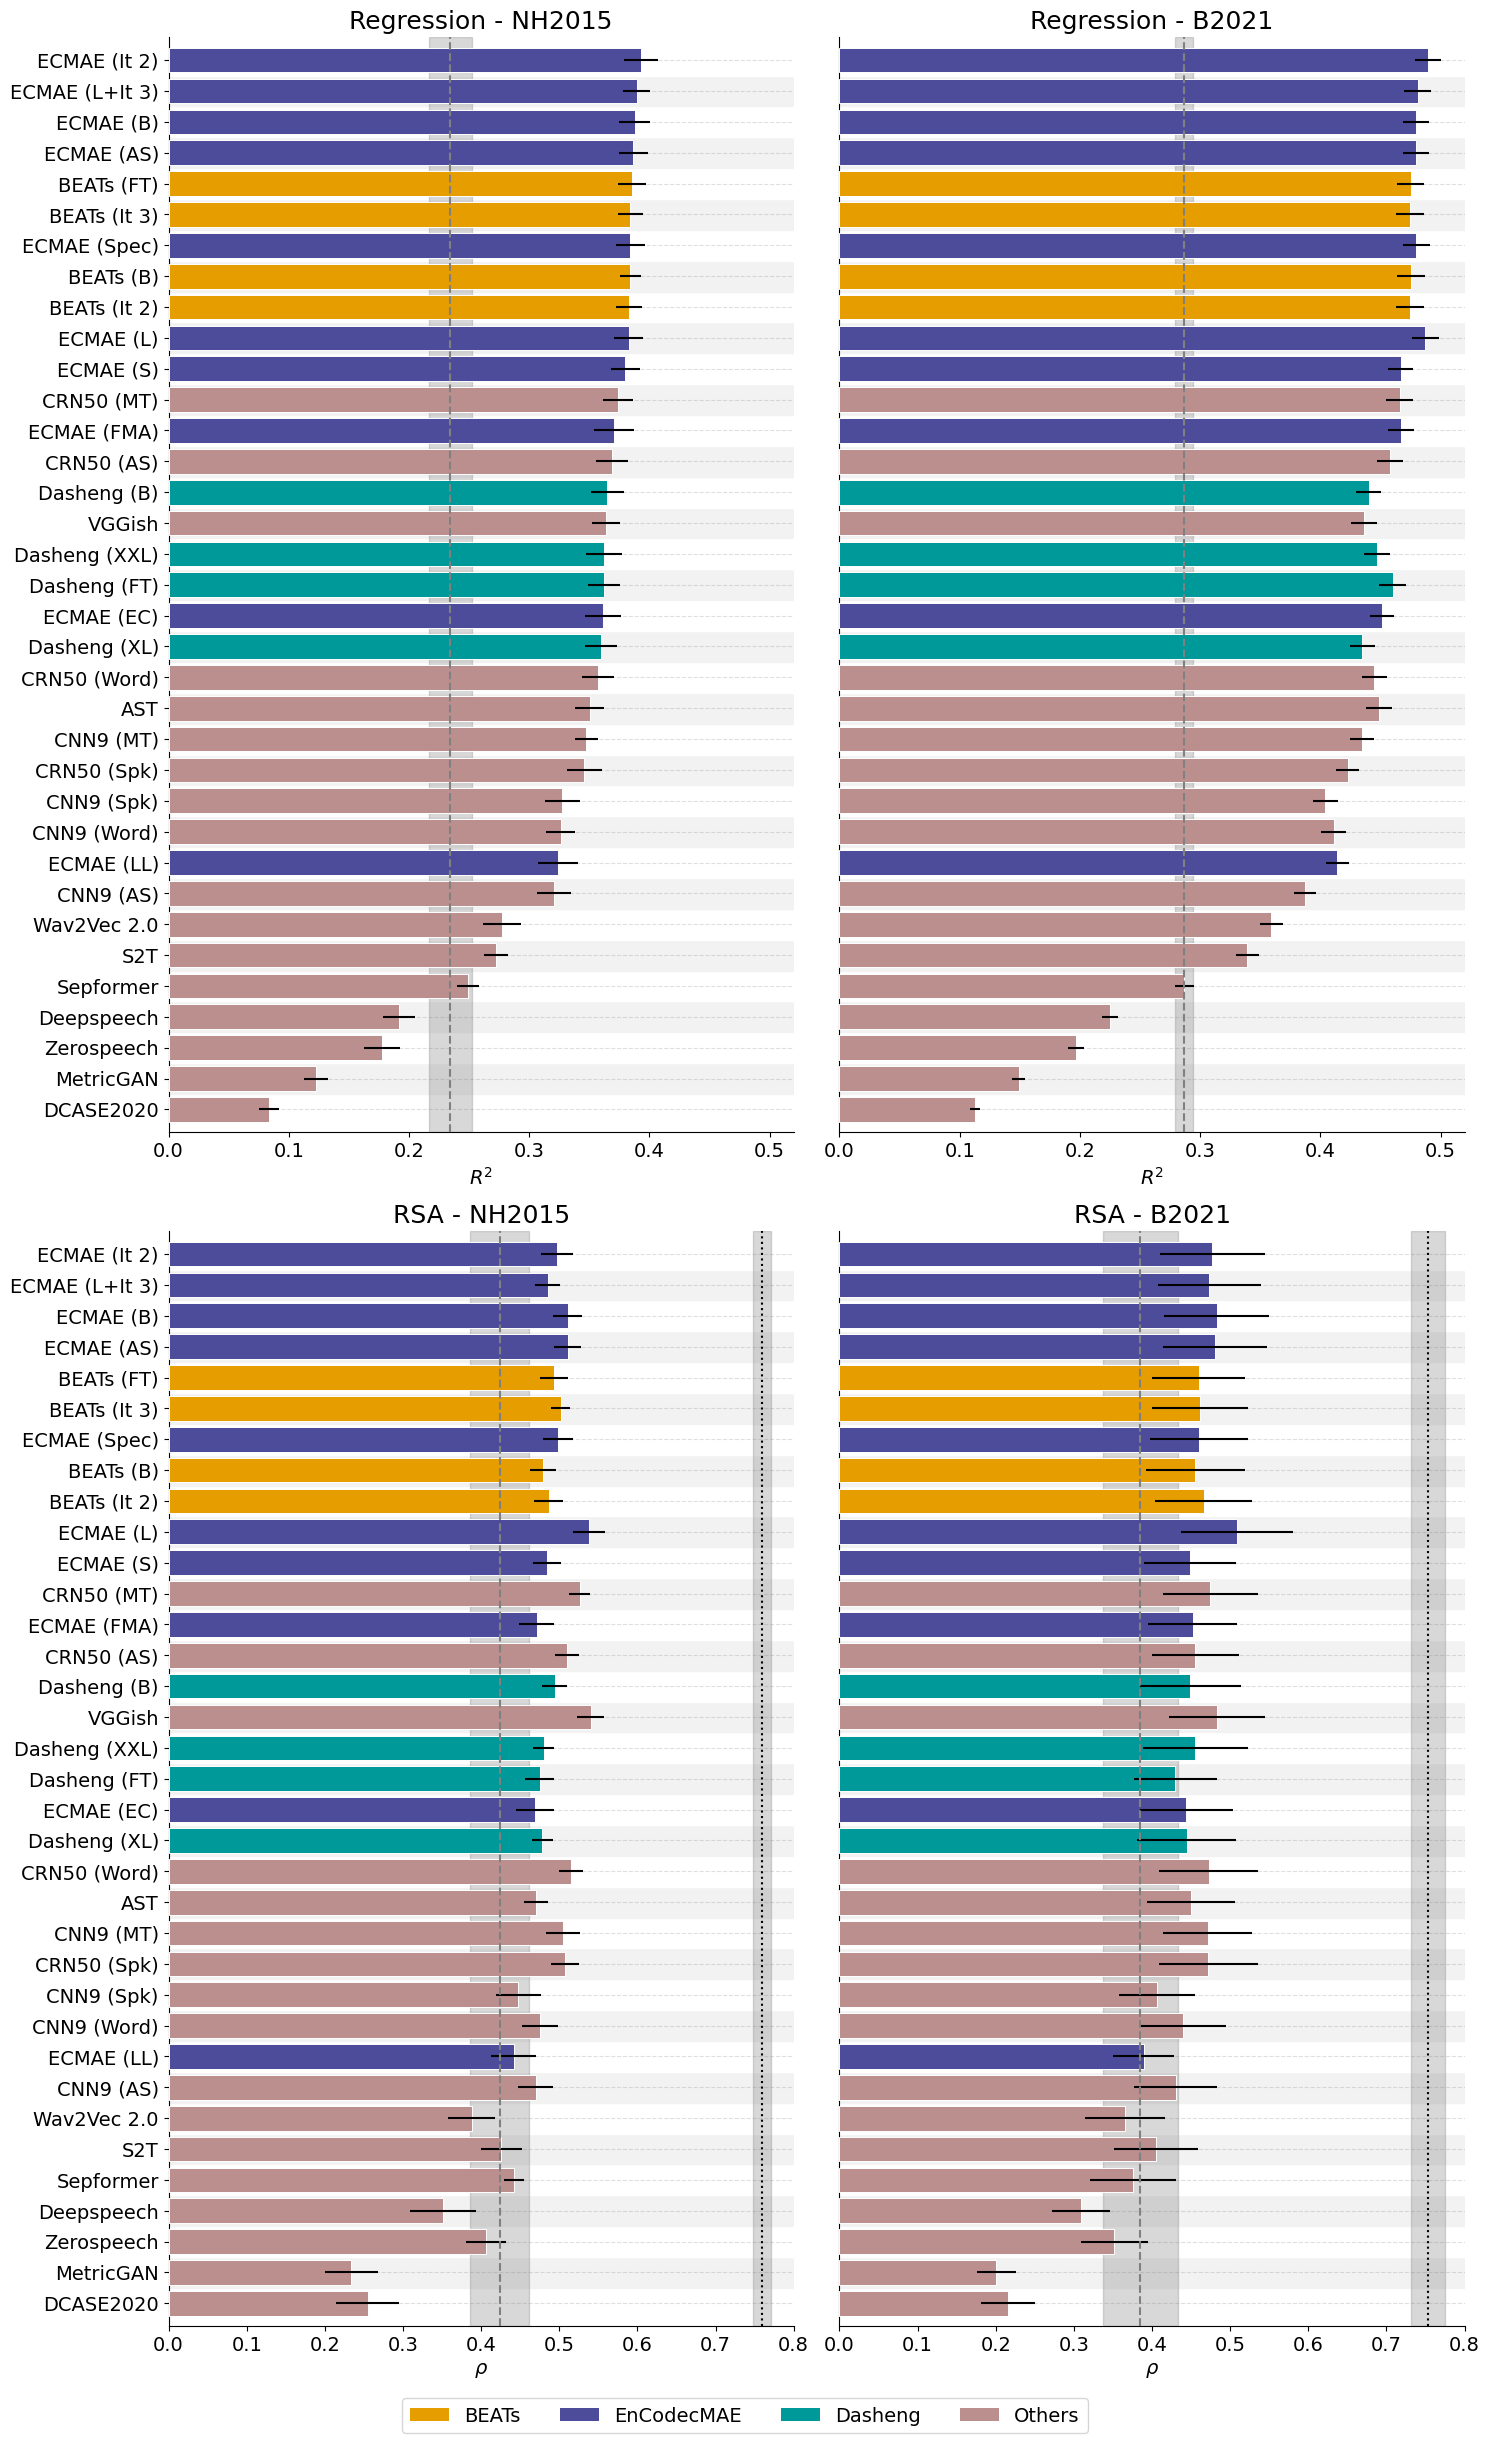

In [5]:
model_order = ['mel256-ec-base', 
                               'mel256-ec-base-as', 
                               'mel256-ec-base-fma', 
                               'mel256-ec-base-ll', 
                               'mel256-ec-small', 
                               'mel256-ec-large', 
                               'mel256-ec-base_st-nopn',
                               'mel256-ec-large_st-nopn',
                               'ec-ec-base',
                               'spec-ec-base',
                               'BEATs_iter1',
                               'BEATs_iter2',
                               'BEATs_iter3',
                               'BEATs_iter3_finetuned_on_AS2M_cpt1',
                               'dasheng_base',
                               'dasheng_06B',
                               'dasheng_12B',
                               'dasheng_base_ft-as',
                               'braindnn_resnet50_word',
                               'braindnn_resnet50_speaker',
                               'braindnn_resnet50_audioset',
                               'braindnn_resnet50_word_speaker_audioset',
                               'braindnn_kell2018_word',
                               'braindnn_kell2018_speaker',
                               'braindnn_kell2018_audioset',
                               'braindnn_kell2018_word_speaker_audioset',
                               'braindnn_ast',
                               'braindnn_vggish',
                               'braindnn_wav2vec2',
                               'braindnn_dcase2020',
                               'braindnn_deepspeech',
                               'braindnn_sepformer',
                               'braindnn_s2t',
                               'braindnn_zerospeech',
                               'braindnn_metricgan'
                               ]
import matplotlib.pyplot as plt

# Update parameters
plt.rcParams.update({
    'xtick.labelsize': 14,   # Font size for the numbers/text on the x-axis
    'ytick.labelsize': 14,   # Font size for the numbers/text on the y-axis
    'axes.labelsize': 14,    # Font size for the x/y axis titles (e.g. "Accuracy")
    'axes.titlesize': 18,     # Font size for the subplot title
    'legend.fontsize': 14
})

inches_per_bar = 0.2
num_models = 35

total_height = (num_models * inches_per_bar) * 2 + 2 # +2 for titles/margins
print(total_height)

make_full_barplot(results_df, None, remove_names=True, figsize=(15,24))
plt.savefig('full_alignment.pdf', bbox_inches="tight")

### Figure S2

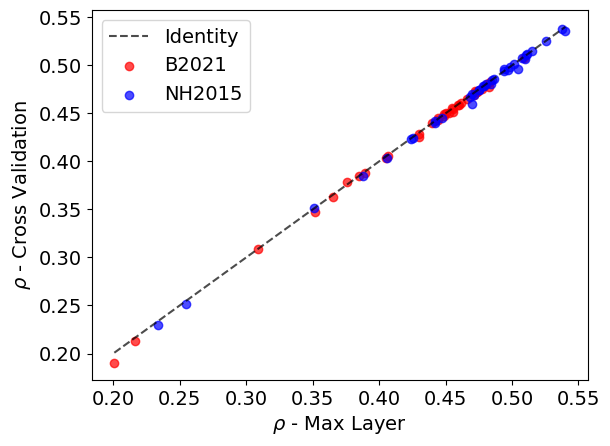

In [12]:
x1 = results_df['rsa_b2021_max'].values
y1 = results_df['rsa_B2021_mean'].values

x2 = results_df['rsa_nh2015_max'].values
y2 = results_df['rsa_NH2015_mean'].values

plt.plot(np.linspace(x1[~np.isnan(x1)].min(), x2[~np.isnan(x1)].max(), 20), 
         np.linspace(x1[~np.isnan(x1)].min(), x2[~np.isnan(x1)].max(), 20), 'k--', alpha=0.7, label='Identity')
plt.scatter(x1, y1, alpha=0.7, label='B2021', c='r')
plt.scatter(x2, y2, alpha=0.7, label='NH2015', c='b')

plt.xlabel(r'$\rho$ - Max Layer')
plt.ylabel(r'$\rho$ - Cross Validation')
plt.legend()

plt.savefig('method-validation.pdf')

### Figure 3

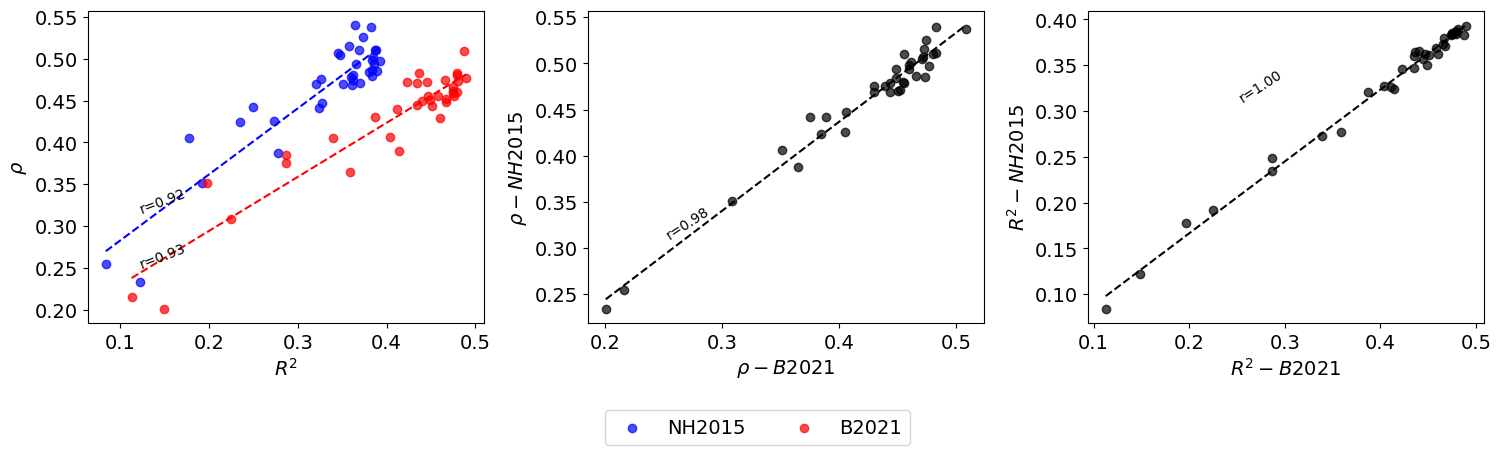

In [6]:
from scipy.stats import linregress, pearsonr

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))


x1 = results_df['REG_NH2015_mean'].values
x2 = results_df['REG_B2021_mean'].values
y1 = results_df['rsa_nh2015_max'].values
y2 = results_df['rsa_b2021_max'].values

mask = ~np.isnan(x1)
x1 = x1[mask]
y1 = y1[mask]
mask = ~np.isnan(x2)
x2 = x2[mask]
y2 = y2[mask]
# regression + stats
slope, intercept, r_value, p_value, std_err = linregress(x1, y1)

# prepare fit line
best_fit_x1 = np.linspace(x1.min(), x1.max(), 200)
best_fit_y1 = best_fit_x1 * slope + intercept

ax[0].scatter(x1, y1, alpha=0.7, c='b', label='NH2015')
#ax[2].plot(np.linspace(x1.min(), x1.max(), 20), 
#         np.linspace(x1.min(), x1.max(), 20), 'k--',
#         label='Identity')
ax[0].plot(best_fit_x1, best_fit_y1, 'b--')

ax[0].text(0.12,0.315,f'r={r_value:.2f}',rotation=21)

slope, intercept, r_value, p_value, std_err = linregress(x2, y2)
best_fit_x2 = np.linspace(x2.min(), x2.max(), 200)
best_fit_y2 = best_fit_x2 * slope + intercept

ax[0].scatter(x2, y2, alpha=0.7, c='r', label='B2021')
#ax[0].plot(np.linspace(x2.min(), x2.max(), 20), 
#         np.linspace(x2.min(), x2.max(), 20), 'k--',
#         label='Identity')
ax[0].plot(best_fit_x2, best_fit_y2, 'r--')
ax[0].text(0.12,0.25,f'r={r_value:.2f}',rotation=21)

ax[0].set_xlabel(r'$R^2$')
ax[0].set_ylabel(r'$\rho$')

x1 = results_df['rsa_b2021_max'].values
y1 = results_df['rsa_nh2015_max'].values

mask = ~np.isnan(x1)
x1 = x1[mask]
y1 = y1[mask]
# regression + stats
slope, intercept, r_value, p_value, std_err = linregress(x1, y1)

# prepare fit line
best_fit_x = np.linspace(x1.min(), x1.max(), 200)
best_fit_y = best_fit_x * slope + intercept

ax[1].scatter(x1, y1, alpha=0.7, c='k')
ax[1].plot(best_fit_x, best_fit_y, 'k--')
ax[1].text(0.25,0.31,f'r={r_value:.2f}',rotation=33)
ax[1].set_xlabel(r'$\rho - B2021$')
ax[1].set_ylabel(r'$\rho - NH2015$')

x1 = results_df['REG_B2021_mean'].values
y1 = results_df['REG_NH2015_mean'].values

mask = ~np.isnan(x1)
x1 = x1[mask]
y1 = y1[mask]
# regression + stats
slope, intercept, r_value, p_value, std_err = linregress(x1, y1)

# prepare fit line
best_fit_x = np.linspace(x1.min(), x1.max(), 200)
best_fit_y = best_fit_x * slope + intercept

ax[2].scatter(x1, y1, alpha=0.7, c='k')
ax[2].plot(best_fit_x, best_fit_y, 'k--')
ax[2].text(0.25,0.31,f'r={r_value:.2f}',rotation=33)
ax[2].set_xlabel(r'$R^2 - B2021$')
ax[2].set_ylabel(r'$R^2 - NH2015$')

fig.legend(ncols=4, loc='lower center', bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()

plt.savefig('compare_datasets_methods.pdf', bbox_inches='tight')

### Figure 4

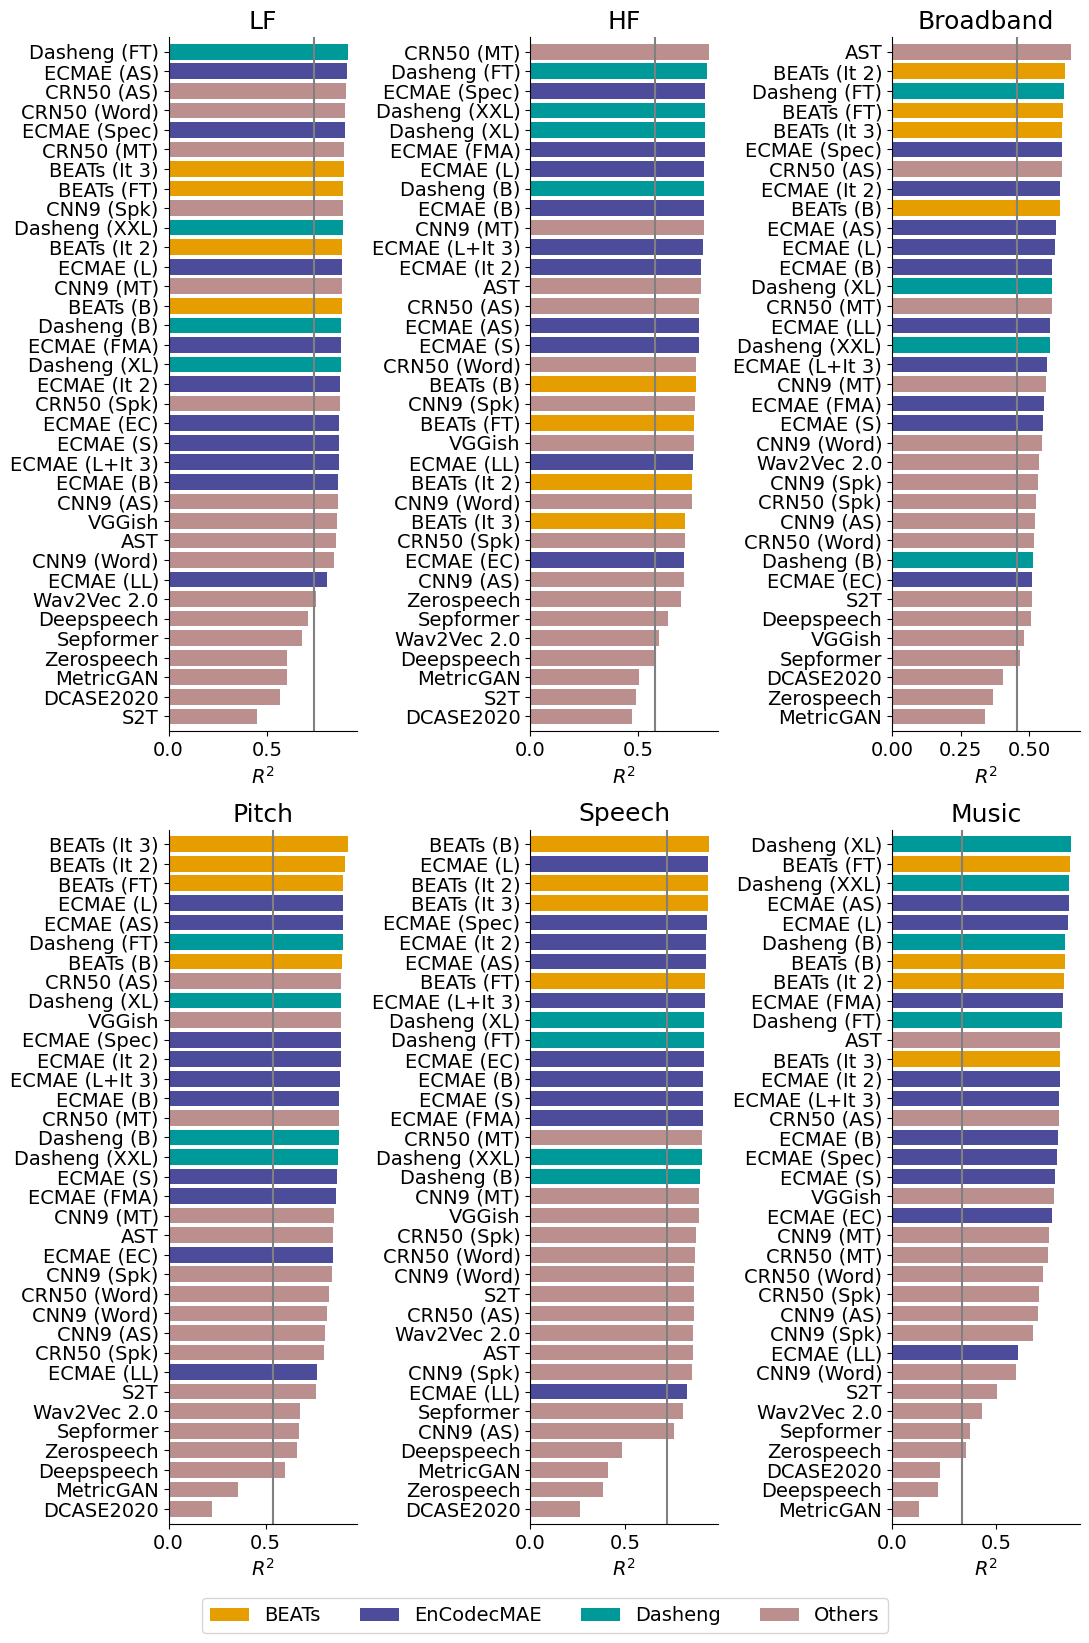

In [6]:
model_subset = ['mel256-ec-base', 
                'mel256-ec-base-as', 
                'mel256-ec-base-fma', 
                'mel256-ec-base-ll', 
                'mel256-ec-large', 
                'mel256-ec-base_st-nopn',
                'mel256-ec-large_st-nopn',
                'BEATs_iter3',
                'BEATs_iter3_finetuned_on_AS2M_cpt1',
                'dasheng_base',
                'dasheng_12B',
                'dasheng_base_ft-as',
               'braindnn_resnet50_word',
               'braindnn_resnet50_speaker',
               'braindnn_resnet50_audioset',
               'braindnn_resnet50_word_speaker_audioset',
               'braindnn_kell2018_word',
               'braindnn_kell2018_speaker',
               'braindnn_kell2018_audioset',
               'braindnn_kell2018_word_speaker_audioset',
                'braindnn_ast',
                'braindnn_vggish',
                'braindnn_wav2vec2',
                'braindnn_dcase2020']
plot_components(results_df, (11,16), models=None)
plt.savefig('components_full.pdf', bbox_inches="tight")

### Figure 5

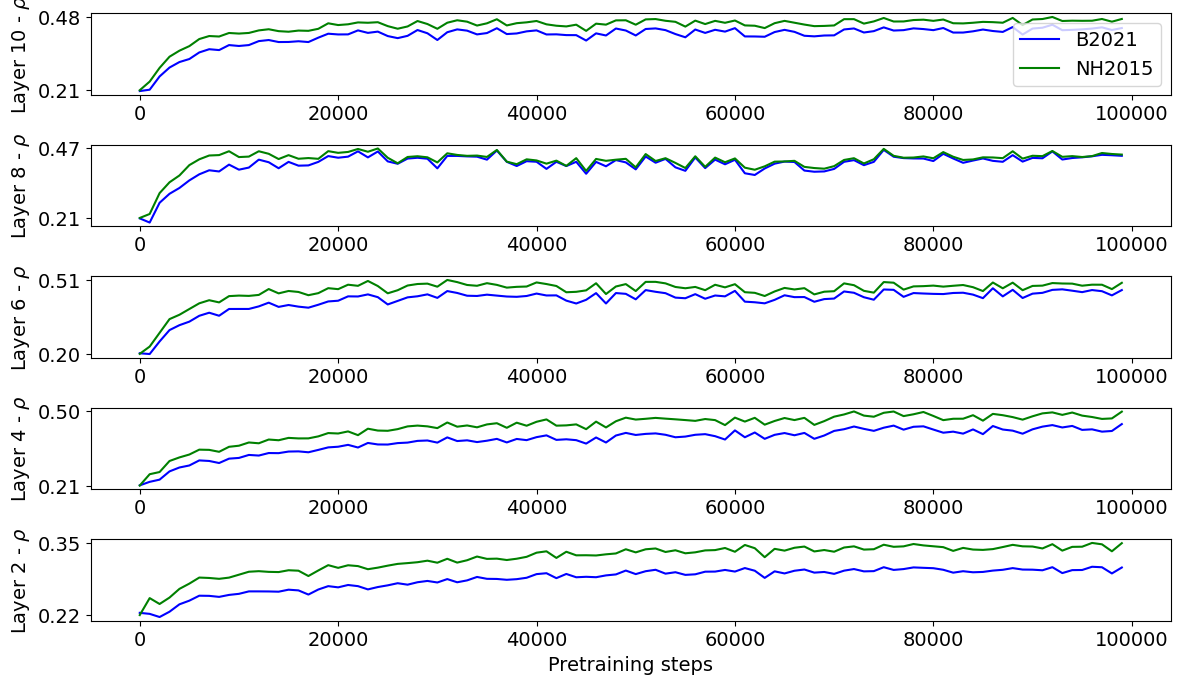

In [7]:
plt.rcParams.update({'font.size': 12})

roi = ''
layers = [1,3,5,7,9]
fig, ax = plt.subplots(nrows=len(layers),figsize=(12,7))
for dataset in ['B2021', 'NH2015']:
    all_alignments = []
    for i in range(0,100000,1000):
        step_df = pd.DataFrame(joblib.load(f'../from_scratch/mel256-ec-base-dynamic/{i}/RSA_{dataset}{roi}.pkl')['subjects_r'])
        all_alignments.append(step_df.groupby('layer')['subj_r'].mean())
    all_layers_curves = []
    for l in layer_map['mel256-ec-base']:
        layer_l = [a.loc[l] for a in all_alignments]
        all_layers_curves.append(layer_l)
    if dataset == 'B2021':
        color = 'blue'
    elif dataset == 'NH2015':
        color = 'green'
    for i,l in enumerate(layers):
        layer_c = np.array(all_layers_curves)[l]
        ax[-i-1].plot(range(0,100000,1000),layer_c,c=color,label=dataset)
        ax[-i-1].set_yticks([layer_c.min(), layer_c.max()], [f'{xi:.2f}' for xi in [layer_c.min(), layer_c.max()]])
        ax[-i-1].set_ylabel(f'Layer {l+1} - $\\rho$')
        #ax[i].axhline(y=results_df.loc[results_df['model']=='braindnn_spectemp_filters']['rsa_{}_max'.format(dataset.lower())].values[0], c=color, linestyle='--')
ax[0].legend()
plt.xlabel('Pretraining steps')
#plt.legend()
plt.tight_layout()
plt.savefig('dynamics-layerwise.pdf')

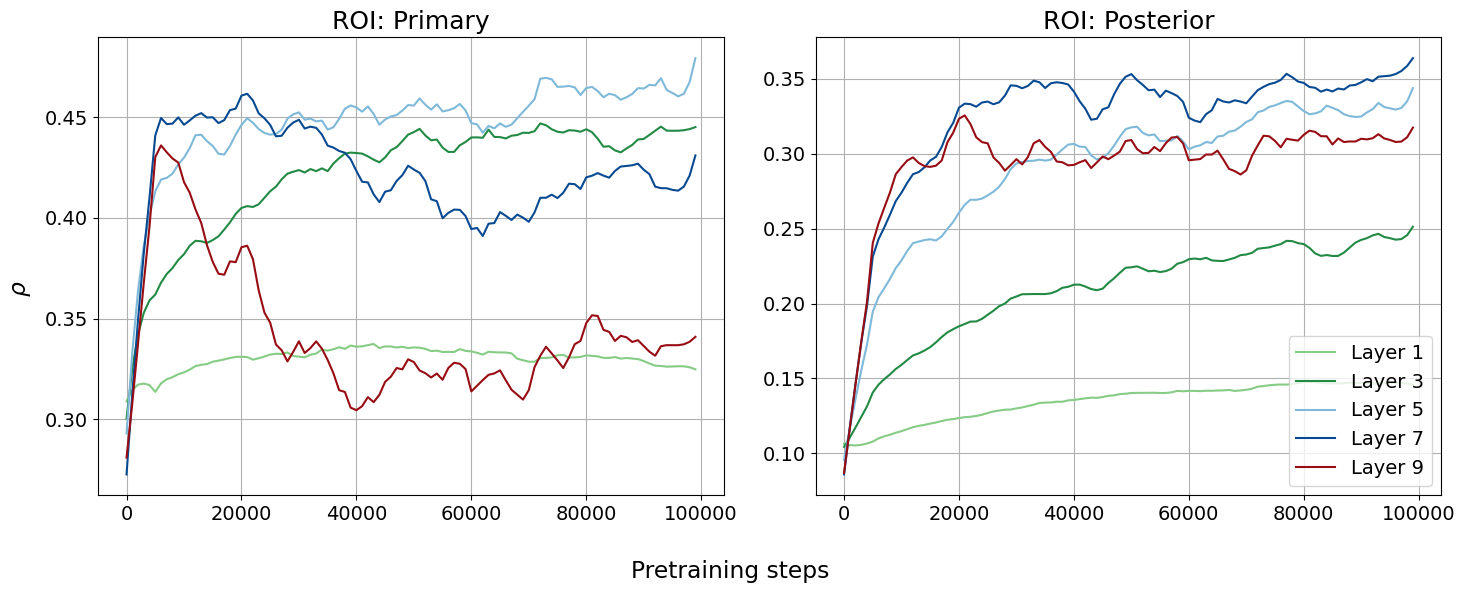

In [8]:
import matplotlib.cm as cm
from scipy.signal import savgol_filter

plt.rcParams.update({'font.size': 14})

colors = [cm.Greens(0.45), cm.Greens(0.5), cm.Greens(0.75),cm.Greens(1.0),
          cm.Blues(0.45), cm.Blues(0.6), cm.Blues(0.9),
          cm.Reds(0.3), cm.Reds(0.9), cm.Reds(0.9)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
for axi, roi in enumerate(['Primary', 'Posterior']):
    all_alignments = []
    for i in range(0,100000,1000):
        step_df = pd.DataFrame(joblib.load(f'../from_scratch/mel256-ec-base-dynamic/{i}/RSA_NH2015{roi}.pkl')['subjects_r'])
        all_alignments.append(step_df.groupby('layer')['subj_r'].mean())
    all_layers_curves = []
    for l in np.array(layer_map['mel256-ec-base'])[[0,2,4,6,8]]:
        layer_l = [a.loc[l] for a in all_alignments]
        layer_l = savgol_filter(layer_l, window_length=10, polyorder=3)
        #all_layers_curves.append(layer_l)
        layer_i = int(l.split('_')[-1])
        ax[axi].plot(range(0,100000,1000), layer_l, color=colors[layer_i], label=f'Layer {layer_i + 1}')
        ax[axi].set_title(f'ROI: {roi}')
        ax[axi].grid('on')

fig.supxlabel('Pretraining steps')
fig.supylabel(r'$\rho$')
plt.tight_layout()
plt.legend()
plt.savefig('roi-rsa-layerwise-dynamic.pdf')

### Figure 6

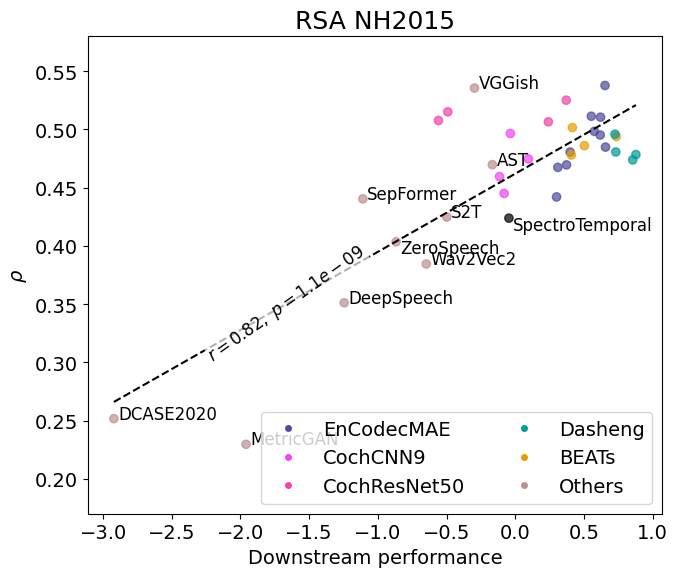

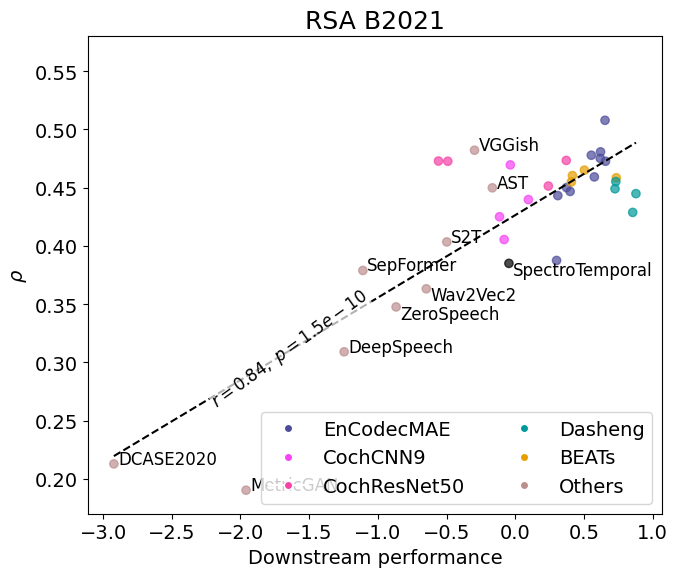

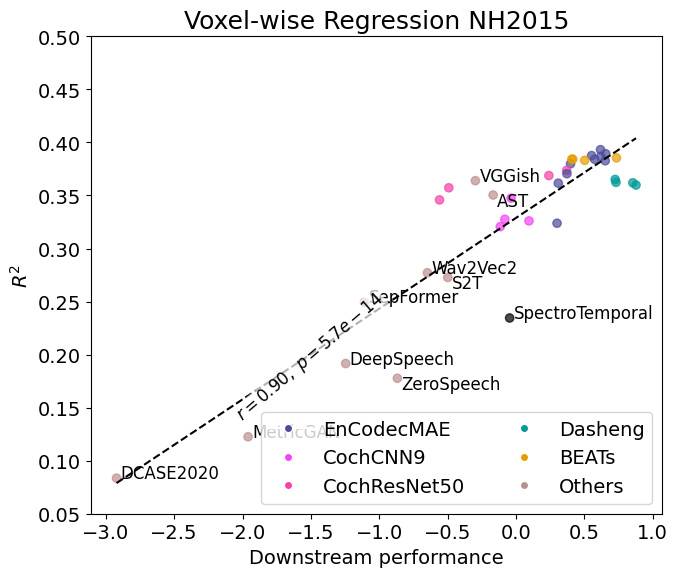

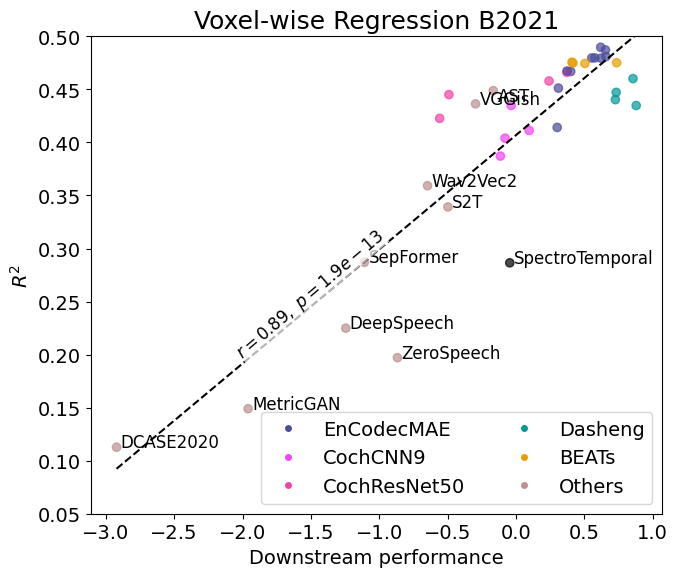

In [9]:
X_SIZE = 7
Y_SIZE = 6
TEXT_FONTSIZE=12
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(X_SIZE,Y_SIZE))
make_correlation_plot(results_df, 'DOWNSTREAM_global', 'rsa_NH2015_mean', 
                      x_offset_pixels=-300,
                      y_offset_pixels=10,
                      text_fontsize=TEXT_FONTSIZE,
                      xlabel='Downstream performance',
                      ylabel='$\\rho$')
plt.ylim(0.17,0.58)
plt.title('RSA NH2015')
plt.tight_layout()
plt.savefig('corr_rsa_nh2015.pdf')

plt.figure(figsize=(X_SIZE,Y_SIZE))
make_correlation_plot(results_df, 'DOWNSTREAM_global', 'rsa_B2021_mean', 
                      x_offset_pixels=-300,
                      y_offset_pixels=10,
                      text_fontsize=TEXT_FONTSIZE,
                      xlabel='Downstream performance',
                      ylabel='$\\rho$')
plt.ylim(0.17,0.58)
plt.title('RSA B2021')
plt.tight_layout()
plt.savefig('corr_rsa_b2021.pdf')

plt.figure(figsize=(X_SIZE,Y_SIZE))
make_correlation_plot(results_df, 'DOWNSTREAM_global', 'REG_NH2015_mean', 
                      x_offset_pixels=-300,
                      y_offset_pixels=10,
                      text_fontsize=TEXT_FONTSIZE,
                      xlabel='Downstream performance',
                      ylabel='$R^2$')
plt.title('Voxel-wise Regression NH2015')
plt.ylim(0.05,0.5)
plt.tight_layout()

plt.savefig('corr_reg_nh2015.pdf')

plt.figure(figsize=(X_SIZE,Y_SIZE))
make_correlation_plot(results_df, 'DOWNSTREAM_global', 'REG_B2021_mean', 
                      x_offset_pixels=-300,
                      y_offset_pixels=10,
                      text_fontsize=TEXT_FONTSIZE,
                      xlabel='Downstream performance',
                      ylabel='$R^2$')
plt.title('Voxel-wise Regression B2021')
plt.ylim(0.05,0.5)
plt.tight_layout()
plt.savefig('corr_reg_b2021.pdf')

### Table 1

In [10]:
from scipy.stats import linregress

downstream_cols = [col for col in results_df.columns 
                   if col.startswith('DOWNSTREAM') and ('zscore' in col) or ('global' in col)]
target_cols = ['rsa_b2021_max', 'rsa_nh2015_max', 'REG_NH2015_mean', 'REG_B2021_mean'] + [f'REG_NH2015comp_{i}' for i in range(6)]

threshold = -1.0  # threshold on the Overall column
overall_col = 'DOWNSTREAM_global'

all_corrs = []

for dc in downstream_cols:
    for tc in target_cols:
        # Raw data
        x = results_df[dc].values
        y = results_df[tc].values
        overall = results_df[overall_col].values

        # Valid mask
        mask = ~np.logical_or(np.isnan(x), np.isnan(y))
        x = x[mask]
        y = y[mask]
        overall = overall[mask]

        # --- Full correlation
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        all_corrs.append({
            'x': dc, 'y': tc, 'subset': 'All',
            'r': r_value, 'p': p_value
        })

        # --- Subset correlation (based on Overall threshold)
        mask2 = overall > threshold
        if mask2.sum() > 1:  # need at least 2 points
            slope, intercept, r_value, p_value, std_err = linregress(x[mask2], y[mask2])
            all_corrs.append({
                'x': dc, 'y': tc, 'subset': f'Overall > {threshold}',
                'r': r_value, 'p': p_value
            })

all_corrs = pd.DataFrame(all_corrs)

# --- Pivot with subset as an index level
r_table = pd.pivot_table(all_corrs, values='r', index=['y', 'subset'], columns='x')
p_table = pd.pivot_table(all_corrs, values='p', index=['y', 'subset'], columns='x')

# --- Apply your MultiIndex renaming
def apply_index_and_columns(df, index_map, col_map):
    tuples = []
    for (y, subset) in df.index:
        base = index_map.get(y, ("Other", y))
        tuples.append(base + (subset,))  # add subset as 3rd level
    new_index = pd.MultiIndex.from_tuples(tuples, names=["Method", "Dataset", "Subset"])
    df = df.copy()
    df.index = new_index
    df = df.rename(columns=col_map)
    return df

col_rename = {'DOWNSTREAM_esc50-v2.0.0-full_zscore': 'ESC',
              'DOWNSTREAM_fsd50k-v1.0-full_zscore': 'FSD',
              'DOWNSTREAM_global': 'Overall',
              'DOWNSTREAM_nsynth_pitch-v2.2.3-50h_zscore': 'NS',
              'DOWNSTREAM_speech_commands-v0.0.2-full_zscore': 'SC',
              'DOWNSTREAM_tfds_crema_d-1.0.0-full_zscore': 'ER',
              'DOWNSTREAM_tfds_gtzan-1.0.0-full_zscore': 'GC'}
r_table = apply_index_and_columns(r_table, {}, col_rename)
p_table = apply_index_and_columns(p_table, {}, col_rename)
r_table = r_table[['NS','GC','SC','ER','FSD','ESC','Overall']]
p_table = p_table[['NS','GC','SC','ER','FSD','ESC','Overall']]

def color_cells(val, p_val):
    if pd.isna(p_val):
        return ''
    if p_val < 0.01:
        return 'background-color: lightgreen'
    elif p_val < 0.05:
        return 'background-color: yellow'
    else:
        return 'background-color: lightcoral'

# Styler function
def highlight_from_p(r_df, p_df):
    styles = pd.DataFrame('', index=r_df.index, columns=r_df.columns)
    for row in r_df.index:
        max_val = r_df.loc[row].max()
        for col in r_df.columns:
            p_val = p_df.loc[row, col]
            style = color_cells(r_df.loc[row, col], p_val)
            if r_df.loc[row, col] == max_val:
                style += '; font-weight: bold'
            styles.loc[row, col] = style
    return styles

# --- Styling
styled = r_table.style.apply(highlight_from_p, p_df=p_table, axis=None).format(precision=3)
latex_code = styled.to_latex(convert_css=True, hrules=True)

styled



In [8]:
print(latex_code)

\begin{tabular}{lllrrrrrrr}
\toprule
 &  & x & NS & GC & SC & ER & FSD & ESC & Overall \\
Method & Dataset & Subset &  &  &  &  &  &  &  \\
\midrule
\multirow[c]{20}{*}{Other} & \multirow[c]{2}{*}{REG_B2021_mean} & All & {\cellcolor{lightgreen}} 0.640 & {\cellcolor{lightgreen}} 0.800 & {\cellcolor{lightgreen}} 0.627 & {\cellcolor{lightgreen}} 0.633 & {\cellcolor{lightgreen}} 0.870 & {\cellcolor{lightgreen}} 0.868 & {\cellcolor{lightgreen}} \bfseries 0.895 \\
 &  & Overall > -1.0 & {\cellcolor{yellow}} 0.362 & {\cellcolor{lightgreen}} 0.468 & {\cellcolor{lightcoral}} 0.223 & {\cellcolor{yellow}} 0.405 & {\cellcolor{lightgreen}} 0.662 & {\cellcolor{lightgreen}} 0.676 & {\cellcolor{lightgreen}} \bfseries 0.703 \\
 & \multirow[c]{2}{*}{REG_NH2015_mean} & All & {\cellcolor{lightgreen}} 0.664 & {\cellcolor{lightgreen}} 0.819 & {\cellcolor{lightgreen}} 0.629 & {\cellcolor{lightgreen}} 0.631 & {\cellcolor{lightgreen}} 0.866 & {\cellcolor{lightgreen}} 0.866 & {\cellcolor{lightgreen}} \bfseries 